# 1 Introduction

Structured Query Language, or **SQL**, is the programming language used with databases, and it is an important skill for any data scientist. In this course, you'll build your SQL using **BigQuery**, a web service that lets you apply SQL to huge datasets.

In this lesson, you'll learn the basics of accessing and examining BigQuery datasets. After you have a handle on these basics, we'll come back to build your SQL skills.

## 1.1 Your first BigQuery commands

To use BigQuery, we'll import the python package below:

In [1]:
from google.cloud import bigquery

The first step in the workflow is to create a `Client` object. As you'll soon see, this `Client` object will play a central role in retrieving information from BigQuery datasets.

In [2]:
# Create a "Client" object
client = bigquery.Client()

We'll work with a dataset of post on [Hacker News](https://news.ycombinator.com/), a website focusing on computer science and cybersecurity news.

In BigQuery, each dataset is contained in a corresponding project. In this case, our `hacker_news` dataset is contained in the `bigquery-public-data` project. To access the dataset,
* We begin by constructing a reference to the dataset with the `dataset()` method.
* Next, we use the `get_dataset()` method, along with the reference we just constructed, to fetch the dataset.

In [3]:
# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

Every dataset is just a collection of tables. You can think of a dataset as a spreadsheet file containing multiple tables, all composed of rows and columns.

We use the `list_tables()` method to list the tables in the dataset.

In [4]:
# List all the tables in the "hacker_news" dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset (there are four!)
for table in tables:
    print(table.table_id)

full


Similar to how we fetched a dataset, we can fetch a table. in the code cell below, we fetch the `full` table in the `hacker_news` dataset.

In [5]:
# Construct a reference to the "full" table
table_ref = dataset_ref.table("full")

# API request - fetch the table
table = client.get_table(table_ref)

In the next section, you'll explore the contents of this table in more detail. For now, take the time to use the image below to consolidate what you've learned so far.

![big-query](images\big-query.png)

## 1.2 Table schema

The structure of a table is called its `schema`. We need to understand a table's schema to effectively pull out the data we want.

In this example, we'll investigate the full table that we fetched above.

In [6]:
# Print information on all the columns in the "full" table in the "hacker_news" dataset
table.schema

[SchemaField('title', 'STRING', 'NULLABLE', None, 'Story title', (), None),
 SchemaField('url', 'STRING', 'NULLABLE', None, 'Story url', (), None),
 SchemaField('text', 'STRING', 'NULLABLE', None, 'Story or comment text', (), None),
 SchemaField('dead', 'BOOLEAN', 'NULLABLE', None, 'Is dead?', (), None),
 SchemaField('by', 'STRING', 'NULLABLE', None, "The username of the item's author.", (), None),
 SchemaField('score', 'INTEGER', 'NULLABLE', None, 'Story score', (), None),
 SchemaField('time', 'INTEGER', 'NULLABLE', None, 'Unix time', (), None),
 SchemaField('timestamp', 'TIMESTAMP', 'NULLABLE', None, 'Timestamp for the unix time', (), None),
 SchemaField('type', 'STRING', 'NULLABLE', None, 'type of details (comment comment_ranking poll story job pollopt)', (), None),
 SchemaField('id', 'INTEGER', 'NULLABLE', None, "The item's unique id.", (), None),
 SchemaField('parent', 'INTEGER', 'NULLABLE', None, 'Parent comment ID', (), None),
 SchemaField('descendants', 'INTEGER', 'NULLABLE', N

Each `SchemaField` tells us about a specific column (which we also refer to as a **field**). In order, the information is:
* The **name** of the column
* The **field type** (or datatype) in the column
* The **mode** of the column (`'NULLABLE'` means that a column allows NULL values, and is the default)
* The **description** of the data in that column

The first field has the SchemaField:
`SchemaField('by', 'string', 'NULLABLE', "The username of the item's author.", ())`

This tell us:
* the field (or column) is called `by`,
* the data in this field is strings,
* NULL values are allowed, and
* it contains the usernames corresponding to each item's author.

We can use the `list_rows()` method to check just the first five lines of the `full` table to make sure this is right. (Sometimes databases have outdated descriptions, so it's good to check.) This returns a BigQuery `RowIterator` object that can quickly be converted to a pandas DataFrame with the `to_dataframe()` method.

In [7]:
import db_dtypes
# Preview the first five lines of the "full" table
client.list_rows(table, max_results=5).to_dataframe()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,"If the crocodile looked him up on Google, we b...",<NA>,raxxorrax,<NA>,1633421535,2021-10-05 08:12:15+00:00,comment,28756662,28750122,<NA>,<NA>,<NA>
1,None,None,What exactly are you looking for? I think Pyto...,<NA>,abiro,<NA>,1569141387,2019-09-22 08:36:27+00:00,comment,21040311,21040141,<NA>,<NA>,<NA>
2,None,None,"Ironically, this very project might help out w...",<NA>,mjevans,<NA>,1505769703,2017-09-18 21:21:43+00:00,comment,15279716,15276626,<NA>,<NA>,<NA>
3,None,None,As you start to gain some experience it can be...,<NA>,every_other,<NA>,1538575027,2018-10-03 13:57:07+00:00,comment,18130207,18128477,<NA>,<NA>,<NA>
4,None,None,"That’s what I was referring to, yes. I heard o...",<NA>,manmal,<NA>,1615664155,2021-03-13 19:35:55+00:00,comment,26449260,26449237,<NA>,<NA>,<NA>


The `list_rows()` method will also let us look at just the information in a specific column. If we want to see the first five entries in the `by` column, for example, we can do that!

In [8]:
# Preview the first five entries in the "by" column of the "full" table
client.list_rows(table, selected_fields=table.schema[:1], max_results=5).to_dataframe()

,title
0,None
1,None
2,None
3,None
4,None


# 2 Select, From & Where

## 2.1 Introduction

Now that you know how to access and examine a dataset, you're ready to write your first SQL query! As you'll soon see, SQL queries will help you sort through a massive dataset, to retrieve only the information that you need.

We'll begin by using the keywords **SELECT**, **FROM**, and **WHERE** to get data from specific columns based on conditions you specify.

For clarity, we'll work with a small imaginary dataset `pet_records` which contains just one table, called `pets`.

![pets-table](images\pets-table.png)

## 2.2 SELECT ... FROM

The most basic SQL query selects a single column from a single table. To do this,
* specify the column you want after the word **SELECT**, and then
* specify the table after the word **FROM**.

For instance, to select the `Name` column (from the `pets` table in the `pet_records` database in the `bigquery-public-data` project), our query would appear as follows:

![select](images\select.png)

Note that when writing an SQL query, the argument we pass to **FROM** is *not* in single or double quotation marks (' or "). It is in backticks (`).

## 2.3 WHERE ...

BigQuery datasets are large, so you'll usuarlly want to return only the rows meeting specific conditions. You can do this using the **WHERE** clause.

The query below returns the entries from the `Name` column that are in rows where the `Animal` column has the text `'Cat'`.

![where](images\where.png)

## 2.4 Example: What are all the U.S. cities in the OpenAQ dataset?

Now that you've got the basics down, let's work through an example with a real dataset. We'll use an [OpenAQ](https://openaq.org/) dataset about air quality.

In [9]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "openaq" dataset
dataset_ref = client.dataset("openaq", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# List all the tables in the "openaq" dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset (there's only one!)
for table in tables:  
    print(table.table_id)

global_air_quality


The dataset contains only one table, called `global_air_quality`. We'll fetch the table and take a peek at the first few rows to see what sort of data it contains.

In [10]:
# Construct a reference to the "global_air_quality" table
table_ref = dataset_ref.table("global_air_quality")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "global_air_quality" table
client.list_rows(table, max_results=5).to_dataframe()

,location,city,country,pollutant,value,timestamp,unit,source_name,latitude,longitude,averaged_over_in_hours,location_geom
0,"Borówiec, ul. Drapałka",Borówiec,PL,bc,0.85217,2022-04-28 07:00:00+00:00,µg/m³,GIOS,1.0,52.276794,17.074114,POINT(52.276794 1)
1,"Kraków, ul. Bulwarowa",Kraków,PL,bc,0.91284,2022-04-27 23:00:00+00:00,µg/m³,GIOS,1.0,50.069308,20.053492,POINT(50.069308 1)
2,"Płock, ul. Reja",Płock,PL,bc,1.41000,2022-03-30 04:00:00+00:00,µg/m³,GIOS,1.0,52.550938,19.709791,POINT(52.550938 1)
3,"Elbląg, ul. Bażyńskiego",Elbląg,PL,bc,0.33607,2022-05-03 13:00:00+00:00,µg/m³,GIOS,1.0,54.167847,19.410942,POINT(54.167847 1)
4,"Piastów, ul. Pułaskiego",Piastów,PL,bc,0.51000,2022-05-11 05:00:00+00:00,µg/m³,GIOS,1.0,52.191728,20.837489,POINT(52.191728 1)


Everything looks goog! So, let's put together a query. Say we want to select all the values from the `city` column that are in rows where the `country` column is `'US'` (for "United States").

In [11]:
# Query to select all the items from the "city" column where the "country" column is 'US'
query = """
        SELECT city
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE country = 'US'
        """

Take the time now to ensure that this query lines up with what you learned above.

## 2.5 Submitting the query to the dataset

We're ready to use this query to get information from the OpenAQ dataset. As in the previous tutorial, the first step is to create a `Client` object.

In [12]:
# Create a "Client" object
client = bigquery.Client()

We begin by setting up the query with the query() method. We run the method with the default parameters, but this method also allows us to specify more complicated settings that you can read about in the documentation. We'll revisit this later.

In [13]:
# Set up the query
query_job = client.query(query)

Next, we run the query and convert the results to a pandas DataFrame

In [14]:
us_cities = query_job.to_dataframe()

In [15]:
# What five cities have the most measurements?
us_cities.city.value_counts().head()

city
Phoenix-Mesa-Scottsdale                     39414
Los Angeles-Long Beach-Santa Ana            27479
Riverside-San Bernardino-Ontario            26887
New York-Northern New Jersey-Long Island    25417
San Francisco-Oakland-Fremont               22710
Name: count, dtype: int64

## 2.6 More queries

If you want multiple columns, you can select them with a comma between the names:

In [16]:
query = """
        SELECT city, country
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE country = 'US'
        """

You can select all columns with a `*` like this:

In [17]:
query = """
        SELECT *
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE country = 'US'
        """

## 2.7 Working with big datasets

BigQuery datasets can be huges. We allow you to do a lot of computation for free, but everyone has some limit.

Don't worry though: we'll teach you how to avoid scanning too much data at once, so that you don't run over your limit.

To begin, you can estimate the size of any query before running it. Here is an example using the (very large!) Hacker News dataset. To see how much data a query will scan, we create a `QueryJobConfig` object and set the `dry_run` parameter to `True`.

In [18]:
# Query to get the score column from every row where the type column has value "job"
query = """
            SELECT score, title
            FROM `bigquery-public-data.hacker_news.full`
            WHERE type = "jon"
        """

# Create a QueryJobConfig object to estimate size of query without running it
dry_run_config = bigquery.QueryJobConfig(dry_run=True)

# API request - dry run query to estimate costs
dry_run_query_job = client.query(query, job_config=dry_run_config)

print("This query will process {} bytes.".format(dry_run_query_job.total_bytes_processed))

This query will process 490833096 bytes.


You can also specify a parameter when running the query to limit how much data you are willing to scan. Here's an example with a low limit.

In [19]:
# Only run the query if it's less than 1 MB
ONE_MB = 1000*1000
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=ONE_MB)

# Set up the query (will only run if it's less than 1 MB)
safe_query_job = client.query(query, job_config=safe_config)

# API request - try to run the query, and return a pandas DataFrame
safe_query_job.to_dataframe()

,score,title


In this case, the query was cancelled, because the limit of 1 MB was exceeded. However, we can increase the limit to run the query successfully!

In [20]:
# Only run the query if it's less than 1 GB
ONE_GB = 1000*1000*1000
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=ONE_GB)

# Set up the query (will only run if it's less than 1 GB)
safe_query_job = client.query(query, job_config=safe_config)

# API request - try to run the query, and return a pandas DataFrame
job_post_scores = safe_query_job.to_dataframe()

# Print average score for job posts
job_post_scores.score.mean()

nan

# 3 Group By, Having & Count

Get more interesting insights directly from your SQL queries

## 3.1 Introduction

Now that you can select raw data, you're ready to learn how to group your data and count things within those groups. This can help you answer questions like:
* How many of each kind of fruit has our store sold?
* How many species of animal has the vet office treated?

To do this, you'll learn about three new tchniques: **GROUP BY**, **HAVING** and **COUNT()**. Once again, we'll use this made-up table of information on pets.

![groupby](images\groupby.png)

## 3.2 COUNT()

COUNT(), as you may have guessed from the name, returns a count of things. If you pass it the name of a column, it will return the number of entries in that column.

For instance, if we **SELECT** the **COUNT()** of the `ID` column in the `pets` table, it will return 4, because there are 4 ID's in the table.

![count](images\count.png)

**COUNT()** is an example of an **aggregate function**, which takes many values and returns one. (Other examples of aggregate functions include **SUM()**, **AVG()**, **MIN()**, and **MAX()**.) As you'll notice in the picture above, aggregate functions introduce strange columns names (lke `f0__`). Later in this tutorial, you'll learn how to change the name to something more descriptive.

## 3.3 GROUP BY
**GROUP BY** takes the name of one or more columns, and treats all rows with the same value in that column as a single group when you apply aggregate functions like **COUNT()**.

For example, say we want to know how many of each type of animal we have in the `pets` table. We can use GROUP BY to group together rows that have the same value in the `Animal` column, while using **COUNT()** to find out how many ID's we have in each group.

![count](images\groupby-1.png)

It returns a table with three rows (one for each distinct animal). We can see that the `pets` table contains 1 rabbit, 1 dog, and 2 cats.

## 3.4 Example: Which Hacker News comments generated the most discussion?

Ready to see an example on a real dataset? The Hacker News dataset contains information on stories and comments from the Hacker News social networking site.

In [21]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "full" table
table_ref = dataset_ref.table("full")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()


,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,"If the crocodile looked him up on Google, we b...",<NA>,raxxorrax,<NA>,1633421535,2021-10-05 08:12:15+00:00,comment,28756662,28750122,<NA>,<NA>,<NA>
1,None,None,What exactly are you looking for? I think Pyto...,<NA>,abiro,<NA>,1569141387,2019-09-22 08:36:27+00:00,comment,21040311,21040141,<NA>,<NA>,<NA>
2,None,None,"Ironically, this very project might help out w...",<NA>,mjevans,<NA>,1505769703,2017-09-18 21:21:43+00:00,comment,15279716,15276626,<NA>,<NA>,<NA>
3,None,None,As you start to gain some experience it can be...,<NA>,every_other,<NA>,1538575027,2018-10-03 13:57:07+00:00,comment,18130207,18128477,<NA>,<NA>,<NA>
4,None,None,"That’s what I was referring to, yes. I heard o...",<NA>,manmal,<NA>,1615664155,2021-03-13 19:35:55+00:00,comment,26449260,26449237,<NA>,<NA>,<NA>


Let's use the table to see which comments generate the most replies. Since:
* the `parent` column indicates the comment that was replied to, and
* the `id`column has the unique ID used to identify each comment,

We can **GROUP BY** the `parent` column and **COUNT()** the  `id` column in order to figure out the number of comments that were made as responses to a specific comment. (*This might not make sense immediately -- take your time here to ensure that everything is clear!*)

Furthermore, since we're only interested in popular comments, we'll look at comments with more than ten replies. So, we'll only returns groups **HAVING** more than ten ID's.

In [22]:
# Query to select comments that received more than 10 replies
query_popular = """
            SELECT parent, COUNT(id)
            FROM `bigquery-public-data.hacker_news.full`
            GROUP BY parent
            HAVING COUNT(id) > 10
            """

Now that our query is ready, let's run it and store the results in a pandas DataFrame:

In [23]:
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_popular, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
popular_comments = query_job.to_dataframe()

# Print the first five rows of the DataFrame
popular_comments.head()

,parent,f0_
0,14505378,46
1,24895395,46
2,3878522,55
3,6176222,66
4,19208700,45


Each row in the `popular_comments` DataFrame corresponds to a comment that received more than ten replies. For instance, the comment with ID `801208` received `56` replies.

## 3.5 Aliasing and other improvements

A couple hints to make your queries even better:
* The column resulting from `COUNT(id)` was called `f0__`. That's not a very descriptive name. You can change the name by adding `AS NumPosts` after you specify the aggregation. This is called **aliasing**, and it will be covered in more detail in an upcoming lesson.
* If you are ever unsure what to put inside the **COUNT()** function, you can do `COUNT(1)` to count the rows in each group. Most people find it especially readable, because we know it's not focusing on other columns. It also scans less data than if supplied column names (making it faster and using less of your data access quota).

Using these tricks, we can rewrite our query:

In [24]:
# Improved version of earlier query, now with aliasing & improved readability
query_improved = """
                 SELECT parent, COUNT(1) AS NumPosts
                 FROM `bigquery-public-data.hacker_news.full`
                 GROUP BY parent
                 HAVING COUNT(1) > 10
                 """
                 
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_improved, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
improved_df = query_job.to_dataframe()

# Print the first five rows of the DataFrame
improved_df.head()

,parent,NumPosts
0,15009759,52
1,18608452,54
2,4941692,50
3,22018946,147
4,21941278,464


Now you have the data you want, and it has descriptive names. That's good style.

## 3.6 Note on using GROUP BY

Note that because it tells SQL how to apply aggregate functions (like **COUNT()**), it doesn't make sense to use **GROUP BY** without an aggregate function. Similarly, if you have any **GROUP BY** clause, then all variables must be passed to either a
1. **GROUP BY** command, or
2. an aggregation function.

Consider the query below:

In [25]:
query_good = """
             SELECT parent, COUNT(id)
             FROM `bigquery-public-data.hacker_news.full`
             GROUP BY parent
             """

Note that there are two variables: `parent` and `id`.
* `parent` was passed to a **GROUP BY** command (in `GROUP BY parent`), and
* `id` was passed to an aggregate function (in `COUNT(id)`).

And this query won't work, because the `author` column isn't passed to an aggregate function or a **GROUP BY** clause:

In [26]:
query_bad = """
            SELECT `by` AS author, parent, COUNT(id)
            FROM `bigquery-public-data.hacker_news.full`
            GROUP BY parent
            """

If make this error, you'll get the error message `SELECT list expression references column (column's name) which is neither grouped nor aggregated at`.

You may notice the ``by`` column in this query is surrounded by backticks. This is because **BY** is a reserved keyword used in clauses including **GROUP BY**. In BigQuery reserved keywords used as identifiers must be quoted in backticks to avoid an error. We also make subsequent references to this column more readable by adding an alias to rename it to `author`.

# 4 Order by

Order your results to focus on the most important data for your use case.

## 4.1 Introduction

So far, you've learned how to use several SQL clauses. For instance, you know how to use **SELECT** to pull specific columns from a table, along with **WHERE** to pull rows that meet specified criteria. You also know how to use aggregate functions like **COUNT()**, along with **GROUP BY** to treat multiple rows as a single group.

Now you'll learn how to change the order of your results using the **ORDER BY** clause, and you'll explore a popular use case by applying ordering to dates. To illustrate what you'll learn in this tutorial, we'll work with a slightly modified version of our familiar `pets` table.

![groupby](images\groupby.png)

## 4.2 ORDER BY

**ORDER BY** is usually the last clause in your query, and it sorts the results returned by the rest of your query.

Notice that the rows are not ordered by the `ID` column. We can quickly remedy this with the query below.

![groupby](images\orderby1.png)

The **ORDER BY** clause also works for columns containing text, where the results show up in alphabetical order.

![groupby](images\orderby2.png)

You can reverse the order using the **DESC** argument (short for 'descending'). The next query sorts the table by the `Animal` column, where the values that are last in alphabetic order are returned first.

![groupby](images\orderby3.png)

### 4.2.1 Dates

Next, we'll talk about dates, because they come up very frequently in real-world databases. There are two ways that dates can be stored in BigQuery: as a **DATE** or as a **DATETIME**.

The **DATE** format has the year first, then the month, and then the day. It looks like this:

```SQL
YYYY-[M]M-[D]D
```
* `YYYY`: Four-digit year
* `[M]M`: One or two digit month
* `[D]D`: One or two digit day

So `2019-01-10` is interpreted as January 10, 2019.

The **DATETIME** format is like the date format ... but with time added at the end.

## 4.3 EXTRACT

Often you'll want to look at part of a date, like the year or the day. You can do this with **EXTRACT**. We'll illustrate this with a slightly different table, called `pets_with_date`.

![extract](images\extract1.png)

The query below returns two columns, where column `Day` contains the day corresponding to each entry the Date column from the `pets_with_date` table:

![extract](images\extract2.png)

SQL is very smart about dates, and we can ask for information beyond just extracting part of the cell. For example, this query returns one column with just the week in the year (between 1 and 53) for each date in the `Date` column:

![extract](images\extract3.png)

You can find all the functions you can use with dates in BigQuery in [this documentation](https://cloud.google.com/bigquery/docs/reference/legacy-sql?hl=es-419#datetimefunctions) under "Date and time functions".

## 4.4 Example: Which day of the week has the most fatal motor accidents?

Let's use the US Traffic Fatality Records database, which contains information on traffic accidents in the US where at least one person died.

In [27]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "nhtsa_traffic_fatalities" dataset
dataset_ref = client.dataset("nhtsa_traffic_fatalities", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "accident_2015" table
table_ref = dataset_ref.table("accident_2015")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "accident_2015" table
client.list_rows(table, max_results=5).to_dataframe()

,state_number,state_name,consecutive_number,number_of_vehicle_forms_submitted_all,number_of_motor_vehicles_in_transport_mvit,number_of_parked_working_vehicles,number_of_forms_submitted_for_persons_not_in_motor_vehicles,number_of_persons_not_in_motor_vehicles_in_transport_mvit,number_of_persons_in_motor_vehicles_in_transport_mvit,number_of_forms_submitted_for_persons_in_motor_vehicles,...,minute_of_ems_arrival_at_hospital,related_factors_crash_level_1,related_factors_crash_level_1_name,related_factors_crash_level_2,related_factors_crash_level_2_name,related_factors_crash_level_3,related_factors_crash_level_3_name,number_of_fatalities,number_of_drunk_drivers,timestamp_of_crash
0,30,Montana,300019,5,5,0,0,0,7,7,...,45,0,None,0,None,0,None,1,0,2015-03-28 14:58:00+00:00
1,39,Ohio,390099,7,7,0,0,0,15,15,...,24,27,Backup Due to Prior Crash,0,None,0,None,1,0,2015-02-14 11:19:00+00:00
2,49,Utah,490123,16,16,0,0,0,28,28,...,99,0,None,0,None,0,None,1,0,2015-04-14 12:24:00+00:00
3,48,Texas,481184,6,5,1,0,5,5,10,...,99,0,None,0,None,0,None,1,0,2015-05-27 16:40:00+00:00
4,41,Oregon,410333,11,11,0,0,0,14,14,...,99,0,None,0,None,0,None,1,0,2015-11-17 18:17:00+00:00


Let's use the table to determine how the number of accidents varies with the day of the week. Since:

* the `consecutive_number` column contains a unique ID for each accident, and
* the `timestamp_of_crash` column contains the date of the accident in DATETIME format,

we can:

* **EXTRACT** the day of the week (as `day_of_week` in the query below) from the `timestamp_of_crash` column, and
* **GROUP BY** the day of the week, before we **COUNT** the `consecutive_number` column to determine the number of accidents for each day of the week.

Then we sort the table with an **ORDER BY** clause, so the days with the most accidents are returned first.

In [28]:
# Query to find out the number of accidents for each day of the week
query = """
        SELECT COUNT(consecutive_number) AS num_accidents, 
               EXTRACT(DAYOFWEEK FROM timestamp_of_crash) AS day_of_week
        FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
        GROUP BY day_of_week
        ORDER BY num_accidents DESC
        """

As usual, we run it as follows:

In [29]:
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**9)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
accidents_by_day = query_job.to_dataframe()

# Print the DataFrame
accidents_by_day

,num_accidents,day_of_week
0,5659,7
1,5298,1
2,4916,6
3,4460,5
4,4182,4
5,4038,2
6,3985,3


Notice that the data is sorted by the `num_accidents` column, where the days with more traffic accidents appear first.

To map the numbers returned for the `day_of_week` column to the actual day, you might consult [the BigQuery documentation](https://cloud.google.com/bigquery/docs/reference/legacy-sql?hl=es-419#dayofweek) on the DAYOFWEEK function. It says that it returns "an integer between 1 (Sunday) and 7 (Saturday), inclusively". So, in 2015, most fatal motor accidents in the US occured on Sunday and Saturday, while the fewest happened on Tuesday.

# 5 As & With

Organize your query for better readability. This becomes especially important for complex queries.

## 5.1 Introduction

With all that you've learned, your SQL queries are getting pretty long, which can make them hard understand (and debug).

You are about to learn how to use **AS** and **WITH** to tidy up your queries and make them easier to read.

Along the way, we'll use the familiar `pets` table, but now it includes the ages of the animals.

![asywtih](images/asywtih.png)

## 5.2 AS

You learned in an earlier tutorial how to use **AS** to rename the columns generated by your queries, which is also known as **aliasing**. This is similar to how Python uses `as` for aliasing when doing imports like `import pandas as pd` or `import seaborn as sns`.

To use **AS** in SQL, insert it right after the column you select. Here's an example of a query *without* an **AS** clause:

![as](images/as1.png)

And here's an example of the same query, but *with* **AS**.

![as](images/as2.png)

These queries return the same information, but in the second query the column returned by the **COUNT()** function will be called `Number`, rather than the default name of `f0__`.

## 5.3 WITH ... AS

On its own, **AS** is a convenient way to clean up the data returned by your query. It's even more powerful when combined with **WITH** in what's called a "common table expression".

A **common table expression** (or **CTE**) is a temporary table that you return within your query. CTEs are helpful for splitting your queries into readable chunks, and you can write queries against them.

For instance, you might want to use the `pets` table to ask questions about older animals in particular. So you can start by creating a CTE which only contains information about animals more than five years old like this:

![withas](images/withas1.png)

While this incomplete query above won't return anything, it creates a CTE that we can then refer to (as `Seniors`) while writing the rest of the query.

We can finish the query by pulling the information that we want from the CTE. The complete query below first creates the CTE, and then returns all of the IDs from it.

![withas](images/withas2.png)

You could do this without a CTE, but if this were the first part of a very long query, removing the CTE would make it much harder to follow.

Also, it's important to note that CTEs only exist inside the query where you create them, and you can't reference them in later queries. So, any query that uses a CTE is always broken into two parts: (1) first, we create the CTE, and then (2) we write a query that uses the CTE.

## 5.4 Example: How many Bitcoin transactions are made per month?

We're going to use a CTE to find out how many Bitcoin transactions were made each day for the entire timespan of a bitcoin transaction dataset.

In [30]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "crypto_bitcoin" dataset
dataset_ref = client.dataset("crypto_bitcoin", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "transactions" table
table_ref = dataset_ref.table("transactions")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "transactions" table
client.list_rows(table, max_results=5).to_dataframe()

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,275,275,1,0,00000000dc55860c8a29c58d45209318fa9e9dc2c1833a...,181,2009-01-12 06:02:13+00:00,2009-01-01,1,2,4000000000.000000000,4000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'f4184...","[{'index': 0, 'script_asm': '04b5abd412d4341b4..."
1,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,275,275,1,0,0000000054487811fc4ff7a95be738aa5ad9320c394c48...,182,2009-01-12 06:12:16+00:00,2009-01-01,1,2,3000000000.000000000,3000000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'a16f3...","[{'index': 0, 'script_asm': '0401518fa1d1e1e3e..."
2,12b5633bad1f9c167d523ad1aa1947b2732a865bf5414e...,276,276,1,0,00000000f46e513f038baf6f2d9a95b2a28d8a6c985bcf...,183,2009-01-12 06:34:22+00:00,2009-01-01,1,2,2900000000.000000000,2900000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '591e9...","[{'index': 0, 'script_asm': '04baa9d3665315562..."
3,828ef3b079f9c23829c56fe86e85b4a69d9e06e5b54ea5...,276,276,1,0,00000000fb5b44edc7a1aa105075564a179d65506e2bd2...,248,2009-01-12 20:04:20+00:00,2009-01-01,1,2,2800000000.000000000,2800000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': '12b56...","[{'index': 0, 'script_asm': '04bed827d37474bef..."
4,35288d269cee1941eaebb2ea85e32b42cdb2b04284a56d...,277,277,1,0,00000000689051c09ff2cd091cc4c22c10b965eb8db3ad...,545,2009-01-15 05:48:32+00:00,2009-01-01,1,2,2500000000.000000000,2500000000.000000000,False,0E-9,"[{'index': 0, 'spent_transaction_hash': 'd71fd...","[{'index': 0, 'script_asm': '044a656f065871a35..."


Since the `block_timestamp` column contains the date of each transaction in DATETIME format, we'll convert these into DATE format using the **DATE()** command.

We do that using a CTE, and then the next part of the query counts the number of transactions for each date and sorts the table so that earlier dates appear first.

In [31]:
# Query to select the number of transactions per date, sorted by date
query_with_CTE = """ 
                 WITH time AS 
                 (
                     SELECT DATE(block_timestamp) AS trans_date
                     FROM `bigquery-public-data.crypto_bitcoin.transactions`
                 )
                 SELECT COUNT(1) AS transactions,
                        trans_date
                 FROM time
                 GROUP BY trans_date
                 ORDER BY trans_date
                 """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_with_CTE, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transactions_by_date = query_job.to_dataframe()

# Print the first five rows
transactions_by_date.head()

,transactions,trans_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12


Since they're returned sorted, we can easily plot the raw results to show us the number of Bitcoin transactions per day over the whole timespan of this dataset.

<Axes: xlabel='trans_date'>

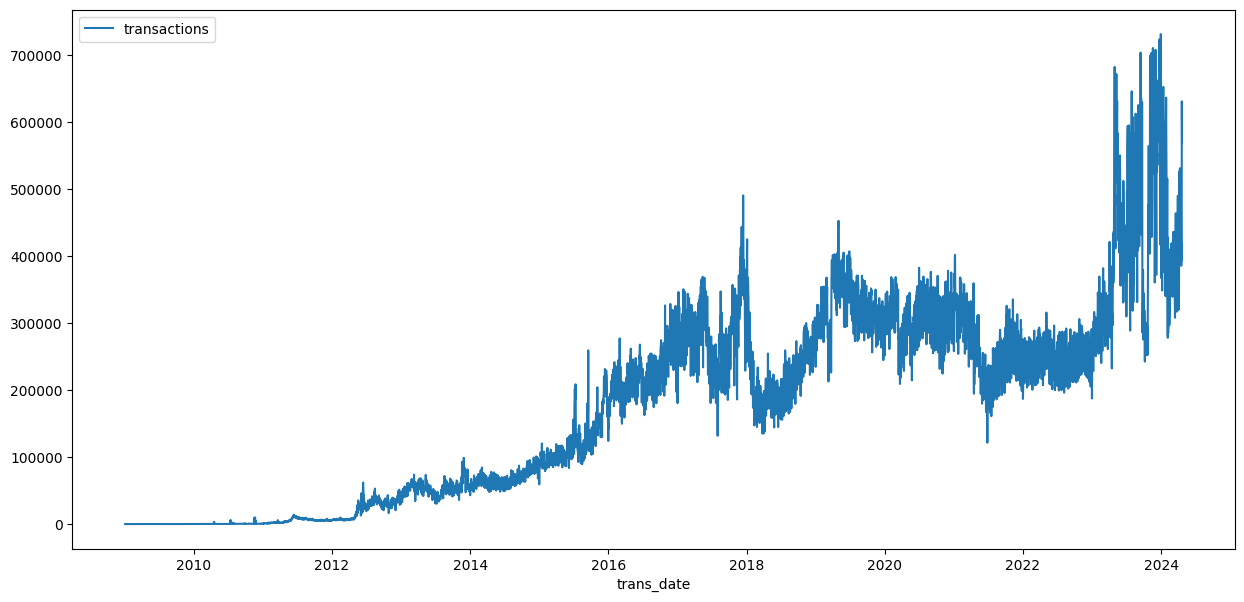

In [32]:
transactions_by_date.set_index('trans_date').plot(figsize=(15, 7))

As you can see, common table expressions (CTEs) let you shift a lot of your data cleaning into SQL. That's an especially good thing in the case of BigQuery, because it is vastly faster than doing the work in Pandas.

# 6 Joining Data

Combine data sources. Critical for almost all real-world data problems

## 6.1 Introduction

You have the tools to obtain data from a single table in whatever format you want it. But what if the data you want is spread across multiple tables?

That's where **JOIN** comes in! **JOIN** is incredibly important in practical SQL workflows. So let's get started.

## 6.2 Example

We'll use our imaginary `pets` table, which has three columns:

* `ID` - ID number for the pet
* `Name` - name of the pet
* `Animal` - type of animal

We'll also add another table, called owners. This table also has three columns:

* `ID` - ID number for the owner (different from the ID number for the pet)
* `Name` - name of the owner
* `Pet_ID` - ID number for the pet that belongs to the owner (which matches the ID number for the pet in the `pets` table)

![join](images/join1.png)

To get information that applies to a certain pet, we match the `ID` column in the `pets` table to the `Pet_ID` column in the `owners` table.

![join](images/join2.png)

For example,

* the `pets` table shows that Dr. Harris Bonkers is the pet with ID 1.
* The `owners` table shows that Aubrey Little is the owner of the pet with ID 1.

Putting these two facts together, Dr. Harris Bonkers is owned by Aubrey Little.

Fortunately, we don't have to do this by hand to figure out which owner goes with which pet. In the next section, you'll learn how to use **JOIN** to create a new table combining information from the `pets` and `owners` tables.


## 6.3 JOIN

Using **JOIN**, we can write a query to create a table with just two columns: the name of the pet and the name of the owner.

![join](images/join3.png)

We combine information from both tables by matching rows where the `ID` column in the `pets` table matches the `Pet_ID` column in the `owners` table.

In the query, **ON** determines which column in each table to use to combine the tables. Notice that since the ID column exists in both tables, we have to clarify which one to use. We use `p.ID` to refer to the `ID` column from the `pets` table, and `o.Pet_ID` refers to the `Pet_ID` column from the `owners` table.

> In general, when you're joining tables, it's a good habit to specify which table each of your columns comes from. That way, you don't have to pull up the schema every time you go back to read the query.

The type of **JOIN** we're using today is called an **INNER JOIN**. That means that a row will only be put in the final output table if the value in the columns you're using to combine them shows up in both the tables you're joining. For example, if Tom's ID number of 4 didn't exist in the `pets` table, we would only get 3 rows back from this query. There are other types of **JOIN**, but an **INNER JOIN** is very widely used, so it's a good one to start with.

## 6.4 Example: How many files are covered by each type of software license?

GitHub is the most popular place to collaborate on software projects. A GitHub **repository** (or **repo**) is a collection of files associated with a specific project.

Most repos on GitHub are shared under a specific legal license, which determines the legal restrictions on how they are used. For our example, we're going to look at how many different files have been released under each license.

In [33]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "github_repos" dataset
dataset_ref = client.dataset("github_repos", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "licenses" table
licenses_ref = dataset_ref.table("licenses")

# API request - fetch the table
licenses_table = client.get_table(licenses_ref)

# Preview the first five lines of the "licenses" table
client.list_rows(licenses_table, max_results=5).to_dataframe()

,repo_name,license
0,autarch/Dist-Zilla-Plugin-Test-TidyAll,artistic-2.0
1,thundergnat/Prime-Factor,artistic-2.0
2,kusha-b-k/Turabian_Engin_Fan,artistic-2.0
3,onlinepremiumoutlet/onlinepremiumoutlet.github.io,artistic-2.0
4,huangyuanlove/LiaoBa_Service,artistic-2.0


The second table is the `sample_files` table, which provides, among other information, the GitHub repo that each file belongs to (in the `repo_name` column). The first several rows of this table are printed below.

In [34]:
# Construct a reference to the "sample_files" table
files_ref = dataset_ref.table("sample_files")

# API request - fetch the table
files_table = client.get_table(files_ref)

# Preview the first five lines of the "sample_files" table
client.list_rows(files_table, max_results=5).to_dataframe()

,repo_name,ref,path,mode,id,symlink_target
0,EOL/eol,refs/heads/master,generate/vendor/railties,40960,0338c33fb3fda57db9e812ac7de969317cad4959,/usr/share/rails-ruby1.8/railties
1,np/ling,refs/heads/master,tests/success/merger_seq_inferred.t/merger_seq...,40960,dd4bb3d5ecabe5044d3fa5a36e0a9bf7ca878209,../../../fixtures/all/merger_seq_inferred.ll
2,np/ling,refs/heads/master,fixtures/sequence/lettype.ll,40960,8fdf536def2633116d65b92b3b9257bcf06e3e45,../all/lettype.ll
3,np/ling,refs/heads/master,fixtures/failure/wrong_order_seq3.ll,40960,c2509ae1196c4bb79d7e60a3d679488ca4a753e9,../all/wrong_order_seq3.ll
4,np/ling,refs/heads/master,issues/sequence/keep.t,40960,5721de3488fb32745dfc11ec482e5dd0331fecaf,../keep.t


Next, we write a query that uses information in both tables to determine how many files are released in each license.

In [35]:
# Query to determine the number of files per license, sorted by number of files
query = """
        SELECT L.license, COUNT(1) AS number_of_files
        FROM `bigquery-public-data.github_repos.sample_files` AS sf
        INNER JOIN `bigquery-public-data.github_repos.licenses` AS L 
            ON sf.repo_name = L.repo_name
        GROUP BY L.license
        ORDER BY number_of_files DESC
        """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
file_count_by_license = query_job.to_dataframe()

It's a big query, and so we'll investigate each piece separately.

![join](images/join3.png)

We'll begin with the **JOIN** (highlighted in blue above). This specifies the sources of data and how to join them. We use **ON** to specify that we combine the tables by matching the values in the `repo_name` columns in the tables.

Next, we'll talk about **SELECT** and **GROUP BY** (highlighted in yellow). The GROUP BY breaks the data into a different group for each license, before we COUNT the number of rows in the `sample_files` table that corresponds to each license. (Remember that you can count the number of rows with `COUNT(1)`.)

Finally, the **ORDER BY** (highlighted in purple) sorts the results so that licenses with more files appear first.

It was a big query, but it gave us a nice table summarizing how many files have been committed under each license:

In [36]:
file_count_by_license

,license,number_of_files
0,mit,20560894
1,gpl-2.0,16608922
2,apache-2.0,7201141
3,gpl-3.0,5107676
4,bsd-3-clause,3465437
5,agpl-3.0,1372100
6,lgpl-2.1,799664
7,bsd-2-clause,692357
8,lgpl-3.0,582277
9,mpl-2.0,457000


You'll use JOIN clauses a lot and get very efficient with them as you get some practice.

# 7. JOINs and UNIONs

Combine information from multiple tables.

## 7.1 Introduction

Now you'll learn about a few more types of **JOIN**, along with how to use **UNIONs** to pull information from multiple tables.

Along the way, we'll work with two imaginary tables, called `owners` and `pets`.

![join](images/join5.png)

Each row of the `owners` table identifies a different pet owner, where the `ID` column is a unique identifier. The `Pet_ID` column (in the owners table) contains the `ID` for the pet that belongs to the owner (this number matches the ID for the pet from the `pets` table).

For example,

* the `pets` table shows that Dr. Harris Bonkers is the pet with ID 1.
* The `owners` table shows that Aubrey Little is the owner of the pet with ID 1.

Putting these two facts together, Dr. Harris Bonkers is owned by Aubrey Little. Likewise, since Veronica Dunn does not have a corresponding `Pet_ID`, she does not have a pet. And, since 5 does not appear in the `Pet_ID` column, Maisie does not have an owner.

## 7.2 JOINs

Recall that we can use an **INNER JOIN** to pull rows from both tables where the value in the `Pet_ID` column in the `owners` table has a match in the `ID` column of the `pets` table.

![join](images/join6.png)

In this case, Veronica Dunn and Maisie are not included in the results. But what if we instead want to create a table containing all pets, regardless of whether they have owners? Or, what if we want to combine all of the rows in both tables? In these cases, we need only use a different type of **JOIN**.

For instance, to create a table containing all rows from the `owners` table, we use a **LEFT JOIN**. In this case, "left" refers to the table that appears before the **JOIN** in the query. ("Right" refers to the table that is after the **JOIN**.)

![join](images/join7.png)

Replacing **INNER JOIN** in the query above with **LEFT JOIN** returns all rows where the two tables have matching entries, along with all of the rows in the left table (whether there is a match or not).

If we instead use a **RIGHT JOIN**, we get the matching rows, along with all rows in the right table (whether there is a match or not).

Finally, a **FULL JOIN** returns all rows from both tables. Note that in general, any row that does not have a match in both tables will have NULL entries for the missing values. You can see this in the image below.

![join](images/join8.png)



## 7.3 UNIONs

As you've seen, **JOINs** horizontally combine results from different tables. If you instead would like to vertically concatenate columns, you can do so with a **UNION**. The example query below combines the `Age` columns from both tables.

![join](images/join9.png)

Note that with a **UNION**, the data types of both columns must be the same, but the column names can be different. (So, for instance, we cannot take the UNION of the `Age` column from the `owners` table and the `Pet_Name` column from the `pets` table.)

We use UNION ALL to include duplicate values - you'll notice that `9` appears in both the `owners` table and the `pets` table, and shows up twice in the concatenated results. If you'd like to drop duplicate values, you need only change **UNION ALL** in the query to **UNION DISTINCT**.

## 7.4 Example

We'll work with the Hacker News dataset.

In [ ]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "comments" table
table_ref = dataset_ref.table("comments")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

Using Kaggle's public dataset BigQuery integration.

You'll also work with the stories table.

In [ ]:
# Construct a reference to the "stories" table
table_ref = dataset_ref.table("stories")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

Since you are already familiar with **JOINs** from the Intro to SQL micro-course, we'll work with a relatively complex example of a JOIN that uses a [common table expression (CTE)](https://www.kaggle.com/code/dansbecker/as-with).

The query below pulls information from the `stories` and `comments` tables to create a table showing all stories posted on January 1, 2012, along with the corresponding number of comments. We use a **LEFT JOIN** so that the results include stories that didn't receive any comments.

In [ ]:
# Query to select all stories posted on January 1, 2012, with number of comments
join_query = """
             WITH c AS
             (
             SELECT parent, COUNT(*) as num_comments
             FROM `bigquery-public-data.hacker_news.comments` 
             GROUP BY parent
             )
             SELECT s.id as story_id, s.by, s.title, c.num_comments
             FROM `bigquery-public-data.hacker_news.stories` AS s
             LEFT JOIN c
             ON s.id = c.parent
             WHERE EXTRACT(DATE FROM s.time_ts) = '2012-01-01'
             ORDER BY c.num_comments DESC
             """

# Run the query, and return a pandas DataFrame
join_result = client.query(join_query).result().to_dataframe()
join_result.head()

Since the results are ordered by the `num_comments` column, stories without comments appear at the end of the DataFrame. (Remember that **NaN** stands for "not a number".)

In [ ]:
join_result.tail()

Next, we write a query to select all usernames corresponding to users who wrote stories or comments on January 1, 2014. We use **UNION DISTINCT** (instead of **UNION ALL**) to ensure that each user appears in the table at most once.

In [ ]:
union_query = """
              SELECT c.by
              FROM `bigquery-public-data.hacker_news.comments` AS c
              WHERE EXTRACT(DATE FROM c.time_ts) = '2014-01-01'
              UNION DISTINCT
              SELECT s.by
              FROM `bigquery-public-data.hacker_news.stories` AS s
              WHERE EXTRACT(DATE FROM s.time_ts) = '2014-01-01'
              """

# Run the query, and return a pandas DataFrame
union_result = client.query(union_query).result().to_dataframe()
union_result.head()

To get the number of users who posted on January 1, 2014, we need only take the length of the DataFrame.

In [ ]:
len(union_result)